### Part 1. Algorithmic Implementation - BFGS Quasi-Newton Algorithm.

In [16]:
# Install libraries
%matplotlib inline
import numpy as np
from sympy import *
from scipy import stats
from scipy.optimize import line_search
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random
import time

### 1) func = x1^2 + x2^2 + x3^2      and     x0 = 1,1,1

In [17]:
################################################################################################
#                                        Trivariate Calculation                                #
################################################################################################

# Start at Example:
#x = np.matrix('1;1;1')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2, x3 = symbols('x1:4')
fn = x1**2 + x2**2 + x3**2

# Lambdify objective function
f = lambdify('x1, x2, x3', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2) 
fnDiffx3 = fn.diff(x3) 
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2], [fnDiffx3]])

# Lambdify
fprime = lambdify('x1, x2, x3', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2) ; fnHessx13 = diff(diff(fn, x1),x3)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) ; fnHessx23 = diff(diff(fn, x2),x3)
fnHessx31 = diff(diff(fn, x3),x1) ; fnHessx32 = diff(diff(fn, x3),x2) ; fnHessx33 = diff(diff(fn, x3),x3) 
fnHess = Matrix([[fnHessx11, fnHessx12, fnHessx13], [fnHessx21, fnHessx22, fnHessx23], [fnHessx31, fnHessx32, fnHessx33]])

# Lambdify
fHess = lambdify('x1, x2, x3', fnHess)

# Calculate Example
#f(x.item((0,0)) , x.item((1,0)) , x.item((2,0)))
#np.asmatrix(fprime(x.item((0,0)) , x.item((1,0)) , x.item((2,0))))
#np.asmatrix(fHess(x.item((0,0)) , x.item((1,0)) , x.item((2,0))))

In [18]:
# Start at
x = np.matrix('1;1;1')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)) , x.item((2,0)))]
Q = np.asmatrix(fHess(x.item((0,0)) , x.item((1,0)) , x.item((2,0))))
beta = np.identity(3)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)) , xnew.item((2,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0)) , xnew.item((2,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0)) , xold.item((2,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    step = (-1 * np.transpose(direction) * fprimeVal)/ (np.transpose(direction) * Q * direction)
    
    # Calculate new x
    xnew = xold + step.item((0,0)) * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)) , xnew.item((2,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step.item((0,0)))  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")    
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0)) , xnew.item((2,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)) , xnew.item((2,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0)) , xnew.item((2,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[1]
 [1]
 [1]]


Iteration:  1
Direction:  [[-2.]
 [-2.]
 [-2.]]
Step Length:  0.5
New Value:  [[ 0.]
 [ 0.]
 [ 0.]]




Local minimum occurs at: [[ 0.]
 [ 0.]
 [ 0.]]
Number of steps: 1
runtime:  0.008984088897705078


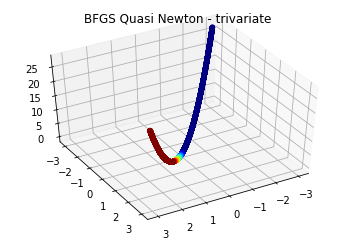

In [19]:
# create the figure, add a 3d axis, set the viewing angle
x = np.linspace(-3,3,10000)
y = np.linspace(-3,3,10000)
z = np.linspace(-3,3,10000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,60)

#ax.scatter(x, y, f(x,y,z), c='b', marker='o')
ax.scatter(x, y, f(x,y,z), facecolors=plt.cm.jet(z))
#ax.scatter(x, y, z, facecolors=plt.cm.jet(f(x,y,z)))
plt.title("BFGS Quasi Newton - trivariate")
plt.show()

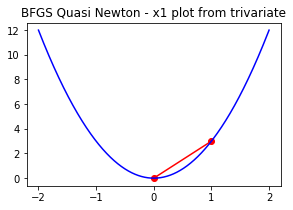

In [20]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)
z = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y,z), c="b")
plt.title("BFGS Quasi Newton - x1 plot from trivariate")

### 2) func = x1^2 + 2*x2^2 - 2*x1*x2 - 2*x2  and x0 = 0,0

In [21]:
################################################################################################
#                                        Bivariate Calculation                                 #
################################################################################################

# Start at Example:
#x = np.matrix('0;0')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2= symbols('x1:3')
fn = x1**2 + 2*x2**2 - 2*x1*x2 - 2*x2

# Lambdify objective function
f = lambdify('x1, x2', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2)  
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2]])

# Lambdify
fprime = lambdify('x1, x2', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) 
fnHess = Matrix([[fnHessx11, fnHessx12], [fnHessx21, fnHessx22]])

# Lambdify
fHess = lambdify('x1, x2', fnHess)

# Calculate Example
#x = np.matrix('0;0')
#f(x.item((0,0)) , x.item((1,0)))
#np.asmatrix(fprime(x.item((0,0)) , x.item((1,0))))
#np.asmatrix(fHess(x.item((0,0)) , x.item((1,0))))

In [22]:
# Start at
x = np.matrix('0;0')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)))]
Q = np.asmatrix(fHess(x.item((0,0)) , x.item((1,0))))
beta = np.identity(2)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    step = (-1 * np.transpose(direction) * fprimeVal)/ (np.transpose(direction) * Q * direction)
    
    # Calculate new x
    xnew = xold + step.item((0,0)) * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step.item((0,0)))  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")    
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[0]
 [0]]


Iteration:  1
Direction:  [[ 0.]
 [ 2.]]
Step Length:  0.25
New Value:  [[ 0. ]
 [ 0.5]]




Iteration:  2
Direction:  [[ 1. ]
 [ 0.5]]
Step Length:  1.0
New Value:  [[ 1.]
 [ 1.]]




Local minimum occurs at: [[ 1.]
 [ 1.]]
Number of steps: 2
runtime:  0.012035846710205078


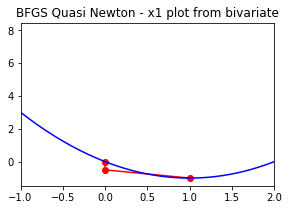

In [23]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y), c="b")
plt.xlim([-1,2])
plt.title("BFGS Quasi Newton - x1 plot from bivariate")

### 3) func = 100*(x2 - x1**2)^2 + (1-x1)^2 and x0 = -1.2,1
#### Notice this is a polynomial problem. Finding the Step size will be challenging as we cannot use Q anymore

In [24]:
################################################################################################
#                                        Bivariate Calculation                                 #
################################################################################################

# Start at Example:
#x = np.matrix('-1.2;1')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2= symbols('x1:3')
fn = 100*(x2 - x1**2)**2 + (1-x1)**2

# Lambdify objective function
f = lambdify('x1, x2', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2)  
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2]])

# Lambdify
fprime = lambdify('x1, x2', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) 
fnHess = Matrix([[fnHessx11, fnHessx12], [fnHessx21, fnHessx22]])

# Lambdify
fHess = lambdify('x1, x2', fnHess)

# Define function to execute optimizes step size using line search
# Hardcoded due to shortage of time. Not good!!!!
def opt_func(x):
    return (-x[0] + 1)**2 + 100*(-x[0]**2 + x[1])**2

def grad(x):
    return [-400*x[0]*(-x[0]**2 + x[1]) + 2*x[0] - 2, -200*x[0]**2 + 200*x[1]]

In [25]:
# Start at
x = np.matrix('-1.2;1')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)))]
beta = np.identity(2)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    # Use scipy line search function to find ideal step size.
    step = line_search(opt_func, grad, np.squeeze(np.asarray(xold)), np.squeeze(np.asarray(direction)))[0]
    
    # Calculate new x
    xnew = xold + step * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step)  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[-1.2]
 [ 1. ]]


Iteration:  1
Direction:  [[ 215.6]
 [  88. ]]
Step Length:  0.000938310275875
New Value:  [[-0.9977003]
 [ 1.0825713]]




Iteration:  2
Direction:  [[ 1.51379751]
 [-3.61038338]]
Step Length:  0.134381034419
New Value:  [[-0.79427463]
 [ 0.59740425]]




Iteration:  3
Direction:  [[ 0.00906143]
 [-0.00221391]]
Step Length:  1.0
New Value:  [[-0.7852132 ]
 [ 0.59519034]]




Iteration:  4
Direction:  [[ 0.25249415]
 [-0.37647776]]
Step Length:  1.0
New Value:  [[-0.53271905]
 [ 0.21871258]]




Iteration:  5
Direction:  [[-0.02545506]
 [ 0.09082232]]
Step Length:  1.0
New Value:  [[-0.5581741]
 [ 0.3095349]]




Iteration:  6
Direction:  [[ 0.12733915]
 [-0.13923766]]
Step Length:  1.0
New Value:  [[-0.43083495]
 [ 0.17029724]]




Iteration:  7
Direction:  [[ 0.40258939]
 [-0.39575624]]
Step Length:  0.27231662474
New Value:  [[-0.32120317]
 [ 0.06252623]]




Iteration:  8
Direction:  [[ 0.05605904]
 [-0.02341039]]
Step Length:  1.0
New 

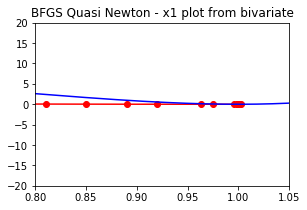

In [32]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y), c="b")
plt.ylim([-20,20])
plt.xlim([0.8,1.05])
plt.title("BFGS Quasi Newton - x1 plot from bivariate")

### 4) func = (x1+x2)^4 + x2^2 and x0 = 2,-2
#### Notice this is a polynomial problem. Finding the Step size will be challenging as we cannot use Q anymore

In [33]:
################################################################################################
#                                        Bivariate Calculation                                 #
################################################################################################

# Start at Example:
#x = np.matrix('2,-2')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2= symbols('x1:3')
fn = (x1+x2)**4 + x2**2

# Lambdify objective function
f = lambdify('x1, x2', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2)  
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2]])

# Lambdify
fprime = lambdify('x1, x2', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) 
fnHess = Matrix([[fnHessx11, fnHessx12], [fnHessx21, fnHessx22]])

# Lambdify
fHess = lambdify('x1, x2', fnHess)

# Define function to execute optimizes step size using line search
# Hardcoded due to shortage of time. Not good!!!!
def opt_func(x):
    return x[1]**2 + (x[0] + x[1])**4

def grad(x):
    return [4*(x[0] + x[1])**3, 2*x[1] + 4*(x[0] + x[1])**3]

In [34]:
# Here step size will be calculated in a different way.
# Start at
x = np.matrix('2;-2')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)))]
beta = np.identity(2)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    # Use scipy line search function to find ideal step size.
    step = line_search(opt_func, grad, np.squeeze(np.asarray(xold)), np.squeeze(np.asarray(direction)))[0]
    
    # Calculate new x
    xnew = xold + step * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step)  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")    
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[ 2]
 [-2]]


Iteration:  1
Direction:  [[ 0.]
 [ 4.]]
Step Length:  0.25
New Value:  [[ 2.]
 [-1.]]




Iteration:  2
Direction:  [[-2.66666667]
 [ 1.44444444]]
Step Length:  1.0
New Value:  [[-0.66666667]
 [ 0.44444444]]




Iteration:  3
Direction:  [[ 0.45379657]
 [-0.43073776]]
Step Length:  1.0
New Value:  [[-0.21287009]
 [ 0.01370669]]




Iteration:  4
Direction:  [[ 0.02435805]
 [-0.01441054]]
Step Length:  1.0
New Value:  [[-0.18851204]
 [-0.00070385]]




Iteration:  5
Direction:  [[ 0.02262781]
 [-0.00606077]]
Step Length:  1.0
New Value:  [[-0.16588423]
 [-0.00676462]]




Iteration:  6
Direction:  [[ 0.0380656 ]
 [-0.00198341]]
Step Length:  1.0
New Value:  [[-0.12781863]
 [-0.00874803]]




Iteration:  7
Direction:  [[ 0.02924645]
 [ 0.00448451]]
Step Length:  1.0
New Value:  [[-0.09857217]
 [-0.00426352]]




Iteration:  8
Direction:  [[ 0.02158077]
 [ 0.00398319]]
Step Length:  1.0
New Value:  [[-0.0769914 ]
 [-0.00028033]]




Iteration:  9

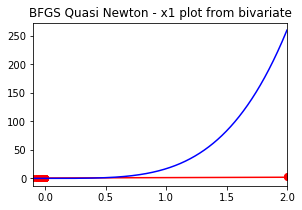

In [35]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y), c="b")
plt.xlim([-0.1,2])
plt.title("BFGS Quasi Newton - x1 plot from bivariate")

### 5.1) func = (x1-1)^2 + (x2-1)^2 + c*(x1^2 + x2^2 - 0.25)^2 and x0 = 1,-1 at c = 1
#### Notice this is a polynomial problem. Finding the Step size will be challenging as we cannot use Q anymore

In [36]:
################################################################################################
#                                        Bivariate Calculation                                 #
################################################################################################

# Start at Example:
#x = np.matrix('2,-2')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2= symbols('x1:3')

# at C=1
fn = (x1-1)**2 + (x2-1)**2 + 1*(x1**2 + x2**2 - 0.25)**2

# Lambdify objective function
f = lambdify('x1, x2', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2)  
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2]])

# Lambdify
fprime = lambdify('x1, x2', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) 
fnHess = Matrix([[fnHessx11, fnHessx12], [fnHessx21, fnHessx22]])

# Lambdify
fHess = lambdify('x1, x2', fnHess)

# Define function to execute optimizes step size using line search
# Hardcoded due to shortage of time. Not good!!!!
def opt_func(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2 + (x[0]**2 + x[1]**2 - 0.25)**2

def grad(x):
    return [4*x[0]*(x[0]**2 + x[1]**2 - 0.25) + 2*x[0] - 2, 4*x[1]*(x[0]**2 + x[1]**2 - 0.25) + 2*x[1] - 2]

In [37]:
# Here step size will be calculated in a different way.
# Start at
x = np.matrix('1;-1')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)))]
beta = np.identity(2)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    # Use scipy line search function to find ideal step size.
    step = line_search(opt_func, grad, np.squeeze(np.asarray(xold)), np.squeeze(np.asarray(direction)))[0]
    
    # Calculate new x
    xnew = xold + step * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step)  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")    
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[ 1]
 [-1]]


Iteration:  1
Direction:  [[ -7.]
 [ 11.]]
Step Length:  0.159187734115
New Value:  [[-0.11431414]
 [ 0.75106508]]




Iteration:  2
Direction:  [[ 1.33354567]
 [ 0.78422954]]
Step Length:  0.225736194404
New Value:  [[ 0.18671539]
 [ 0.92809407]]




Iteration:  3
Direction:  [[ 0.33963704]
 [-0.2678212 ]]
Step Length:  1.0
New Value:  [[ 0.52635243]
 [ 0.66027286]]




Iteration:  4
Direction:  [[ 0.0076482 ]
 [-0.07432081]]
Step Length:  1.0
New Value:  [[ 0.53400063]
 [ 0.58595205]]




Iteration:  5
Direction:  [[ 0.03855413]
 [-0.02303126]]
Step Length:  1.0
New Value:  [[ 0.57255476]
 [ 0.56292079]]




Iteration:  6
Direction:  [[-0.00865956]
 [ 0.00137346]]
Step Length:  1.0
New Value:  [[ 0.5638952 ]
 [ 0.56429425]]




Iteration:  7
Direction:  [[ 0.00018783]
 [-0.00019757]]
Step Length:  1.0
New Value:  [[ 0.56408302]
 [ 0.56409669]]




Iteration:  8
Direction:  [[  4.00017301e-06]
 [ -9.66944918e-06]]
Step Length:  1.0
New Value: 

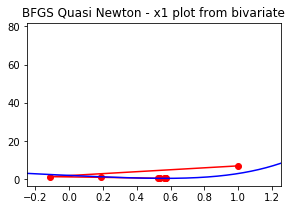

In [38]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y), c="b")
plt.xlim([-0.25,1.25])
plt.title("BFGS Quasi Newton - x1 plot from bivariate")

### 5.2) func = (x1-1)^2 + (x2-1)^2 + c*(x1^2 + x2^2 - 0.25)^2 and x0 = 1,-1 at c = 10
#### Notice this is a polynomial problem. Finding the Step size will be challenging as we cannot use Q anymore

In [39]:
################################################################################################
#                                        Bivariate Calculation                                 #
################################################################################################

# Start at Example:
#x = np.matrix('2,-2')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2= symbols('x1:3')

# at C=10
fn = (x1-1)**2 + (x2-1)**2 + 10*(x1**2 + x2**2 - 0.25)**2

# Lambdify objective function
f = lambdify('x1, x2', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2)  
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2]])

# Lambdify
fprime = lambdify('x1, x2', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) 
fnHess = Matrix([[fnHessx11, fnHessx12], [fnHessx21, fnHessx22]])

# Lambdify
fHess = lambdify('x1, x2', fnHess)

# Define function to execute optimizes step size using line search
# Hardcoded due to shortage of time. Not good!!!!
def opt_func(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2 + 10*(x[0]**2 + x[1]**2 - 0.25)**2

def grad(x):
    return [40*x[0]*(x[0]**2 + x[1]**2 - 0.25) + 2*x[0] - 2, 40*x[1]*(x[0]**2 + x[1]**2 - 0.25) + 2*x[1] - 2]

In [40]:
# Here step size will be calculated in a different way.
# Start at
x = np.matrix('1;-1')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)))]
beta = np.identity(2)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    # Use scipy line search function to find ideal step size.
    step = line_search(opt_func, grad, np.squeeze(np.asarray(xold)), np.squeeze(np.asarray(direction)))[0]
    
    # Calculate new x
    xnew = xold + step * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step)  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")    
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[ 1]
 [-1]]


Iteration:  1
Direction:  [[-70.]
 [ 74.]]
Step Length:  0.0192008194204
New Value:  [[-0.34405736]
 [ 0.42086064]]




Iteration:  2
Direction:  [[ 1.88694684]
 [ 1.82648094]]
Step Length:  0.11904019881
New Value:  [[-0.11943483]
 [ 0.63828529]]




Iteration:  3
Direction:  [[ 0.08811671]
 [-0.03234509]]
Step Length:  1.0
New Value:  [[-0.03131812]
 [ 0.6059402 ]]




Iteration:  4
Direction:  [[ 0.31681088]
 [ 0.00432527]]
Step Length:  1.0
New Value:  [[ 0.28549276]
 [ 0.61026547]]




Iteration:  5
Direction:  [[ 0.00438825]
 [-0.14924754]]
Step Length:  1.0
New Value:  [[ 0.28988101]
 [ 0.46101793]]




Iteration:  6
Direction:  [[ 0.09599759]
 [-0.03214937]]
Step Length:  1.0
New Value:  [[ 0.38587861]
 [ 0.42886856]]




Iteration:  7
Direction:  [[ 0.0122278 ]
 [-0.01454921]]
Step Length:  1.0
New Value:  [[ 0.39810641]
 [ 0.41431935]]




Iteration:  8
Direction:  [[ 0.00306133]
 [-0.01091019]]
Step Length:  1.0
New Value:  [[ 0.4011

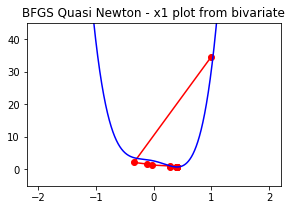

In [41]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y), c="b")
plt.ylim([-5,45])
plt.title("BFGS Quasi Newton - x1 plot from bivariate")

### 5.3) func = (x1-1)^2 + (x2-1)^2 + c*(x1^2 + x2^2 - 0.25)^2 and x0 = 1,-1 at c = 100
#### Notice this is a polynomial problem. Finding the Step size will be challenging as we cannot use Q anymore

In [42]:
################################################################################################
#                                        Bivariate Calculation                                 #
################################################################################################

# Start at Example:
#x = np.matrix('2,-2')

########################################## Objective ###########################################
# Define and symbolize objective function 
x1, x2= symbols('x1:3')

# at C=100
fn = (x1-1)**2 + (x2-1)**2 + 100*(x1**2 + x2**2 - 0.25)**2

# Lambdify objective function
f = lambdify('x1, x2', fn)

########################################## Derivative ###########################################

# Derivative
fnDiffx1 = fn.diff(x1)
fnDiffx2 = fn.diff(x2)  
fnDeriv = Matrix([[fnDiffx1], [fnDiffx2]])

# Lambdify
fprime = lambdify('x1, x2', fnDeriv)

########################################## Hessian    ###########################################

# Hessian
fnHessx11 = diff(diff(fn, x1),x1) ; fnHessx12 = diff(diff(fn, x1),x2)
fnHessx21 = diff(diff(fn, x2),x1) ; fnHessx22 = diff(diff(fn, x2),x2) 
fnHess = Matrix([[fnHessx11, fnHessx12], [fnHessx21, fnHessx22]])

# Lambdify
fHess = lambdify('x1, x2', fnHess)

# Define function to execute optimizes step size using line search
# Hardcoded due to shortage of time. Not good!!!!
def opt_func(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2 + 100*(x[0]**2 + x[1]**2 - 0.25)**2

def grad(x):
    return [400*x[0]*(x[0]**2 + x[1]**2 - 0.25) + 2*x[0] - 2, 400*x[1]*(x[0]**2 + x[1]**2 - 0.25) + 2*x[1] - 2]

In [43]:
# Here step size will be calculated in a different way.
# Start at
x = np.matrix('1;-1')
print ("Initial Starting Point at:", x)

# Set convergence Precision and iteration limit
e = pow(10,-8)
itMax = 1000

# Assigning initial values
xold = np.matrix('0;0')
xnew = x
xlist, ylist = [xnew], [f(x.item((0,0)) , x.item((1,0)))]
beta = np.identity(2)

# Loop Condition for next iteration
fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

# Calculate runtime
starttime = time.time()

# Formula for BFGS
while fprimeNorm/(1 + f_abs) > e:
    xold = xnew
    fprimeVal = np.asmatrix(fprime(xold.item((0,0)) , xold.item((1,0))))
        
    # Halting at itMax iterations to avoid convergence failure and computational overhead.    
    if (len(xlist) == itMax) :
        break;
    
    # Calculate direction
    direction = -1 * np.linalg.inv(beta) * fprimeVal
    
    # Calculate step size
    # Use scipy line search function to find ideal step size.
    step = line_search(opt_func, grad, np.squeeze(np.asarray(xold)), np.squeeze(np.asarray(direction)))[0]
    
    # Calculate new x
    xnew = xold + step * direction
    
    # Update Secant Estimates for next iteration
    s = xnew - xold
    
    fprimeValNew = np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0))))
    y = fprimeValNew - fprimeVal
    
    beta_del = ((-1*(beta*s)*np.transpose(beta*s) / (np.transpose(s)*beta*s))) + ((y*np.transpose(y))/(np.transpose(y)*s))
    beta = beta + beta_del
    
    # Print search Dir, step length, new value: For first 10 and last 5 iterations
    if (len(xlist) <= 10):
        print("\n")
        print("Iteration: ",len(xlist))    
        print("Direction: ",direction)    
        print("Step Length: ",step)  
        print("New Value: ",xnew)
        print("\n")
        
    if (len(xlist) > 10): 
        print(".", end = "")    
    
    xlist.append(xnew)
    ylist.append(f(xnew.item((0,0)) , xnew.item((1,0))))
    
    # Loop Condition for next iteration
    fprimeNorm = np.linalg.norm(np.asmatrix(fprime(xnew.item((0,0)) , xnew.item((1,0)))))
    f_abs = abs(f(xnew.item((0,0)) , xnew.item((1,0))))

runtime = time.time() - starttime 
print("\n")

if (len(xlist) == itMax):
    print ("No Solution has been found after %s iterations" %itMax)
    
else:
    print ("Local minimum occurs at:", xnew)
    print ("Number of steps:", len(xlist)-1)

print ("runtime: ", runtime)

Initial Starting Point at: [[ 1]
 [-1]]


Iteration:  1
Direction:  [[-700.]
 [ 704.]]
Step Length:  0.00191347993345
New Value:  [[-0.33943595]
 [ 0.34708987]]




Iteration:  2
Direction:  [[ 2.01180109]
 [ 2.01680699]]
Step Length:  0.0799696418004
New Value:  [[-0.17855294]
 [ 0.50837321]]




Iteration:  3
Direction:  [[-0.02821801]
 [-0.04266513]]
Step Length:  1.0
New Value:  [[-0.20677095]
 [ 0.46570807]]




Iteration:  4
Direction:  [[ 0.05040275]
 [ 0.02491979]]
Step Length:  1.0
New Value:  [[-0.1563682 ]
 [ 0.49062786]]




Iteration:  5
Direction:  [[ 0.27266324]
 [ 0.1051368 ]]
Step Length:  0.242110088493
New Value:  [[-0.09035368]
 [ 0.51608254]]




Iteration:  6
Direction:  [[ 0.14969234]
 [ 0.03239516]]
Step Length:  1.0
New Value:  [[ 0.05933865]
 [ 0.5484777 ]]




Iteration:  7
Direction:  [[-0.02187096]
 [-0.0309339 ]]
Step Length:  1.0
New Value:  [[ 0.03746769]
 [ 0.5175438 ]]




Iteration:  8
Direction:  [[ 0.06826828]
 [-0.01612887]]
Step Length:  1.0
New V

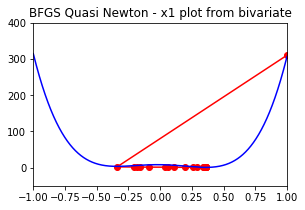

In [44]:
x = np.linspace(-2,2,10000)
y = np.linspace(-2,2,10000)

# Get x1 values. i.e. first column from matrix
x1valsArray = np.asmatrix(np.asarray(xlist))
x1vals = list(np.squeeze(np.matrix.tolist(x1valsArray[:,0])))

# Plot the descent
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x1vals,ylist,c="r")

plt.plot(x1vals,ylist,c="r")
plt.plot(x,f(x,y), c="b")
plt.ylim([-50,400])
plt.xlim([-1,1])
plt.title("BFGS Quasi Newton - x1 plot from bivariate")